# HLA-A allele clustering

## Section 1: Setup

In [41]:
from gentype import EnsemblClient, DataManager, PiCollapsedNonparametricGibbsSampler
from gentype import AlleleMM
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np

Set up Classes:

In [2]:
Database_Name = "Gentype_DB.db"
client = EnsemblClient()
data_manager = DataManager(client, Database_Name)

Initialize storable data:

In [3]:
fetched = False
inference_matrix = None
models = None

Restore stored data:

In [4]:
#%store -d fetched # if you want to refetch the data, uncomment this line
#%store -d inference_matrix # if you want to recompute the inference_matrix, uncomment this line
#%store -d models # if you want to recompute the models, uncomment this line
%store -r

## Section 2: Collecting and preparing data

Fetches all HLA-A data obtained in 1000 Genomes project phase3 and stores them in a local sqlite server. This only needs to be done once but might take a while.

In [5]:
if not fetched:
    data_manager.fetch_all(29941260, 29945884, "6", report_progress = True)
fetched = True
%store fetched

Stored 'fetched' (bool)


The following generates an inference matrix from the data provided by the local database. The inference matrix can be constructed with respect to a population and a section specified by start and end. Be sure to fetch the according population before constructing the matrix. If _sum_allels = True_ is passed, the expression for an individual per allele will be summed (if expressed on both -> 2, on one -> 1, on neither -> 0). Otherwise each strand will be represented by a seperate row.

In [6]:
if inference_matrix is None:
    inference_matrix, individual_map, variation_map = data_manager.generate_inference_matrix(start = 29941260, end = 29945884, population = "ALL")
%store inference_matrix 
%store individual_map 
%store variation_map
inference_matrix.shape

Stored 'inference_matrix' (ndarray)
Stored 'individual_map' (dict)
Stored 'variation_map' (dict)


(5008, 438)

Mean number of variations per allele, for HLA-A as expected high.

In [7]:
inference_matrix.sum(axis=1).mean()

91.09704472843451

## Section 3: Training the Model

Train models with different initializations without seeding.

Here we compute different models with varying dirichlet prior alpha. This prior is proportional to the probability of creating a new cluster, therefore inference with high alphas tends to begin with a higher number of clusters. This might take a while.

Model 0:


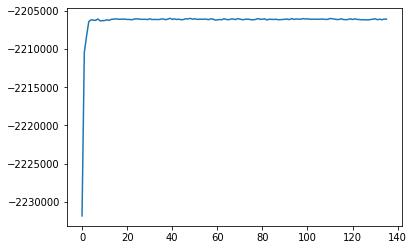

Model 1:


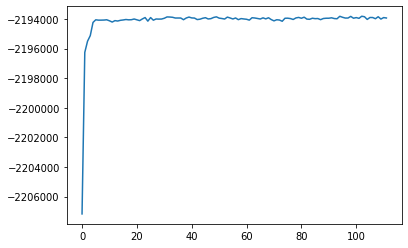

Model 2:


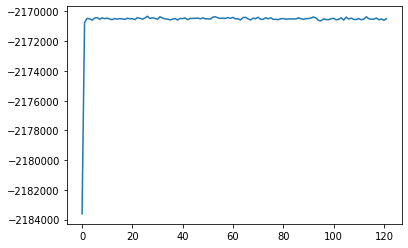

Stored 'models' (list)


In [8]:
if models is None:
    models = [PiCollapsedNonparametricGibbsSampler(42), PiCollapsedNonparametricGibbsSampler(42), PiCollapsedNonparametricGibbsSampler(42)]
    for i in range(0, len(models)):
        print("Model {}:".format(i))
        models[i].fit(inference_matrix, num_burn_in_steps = 100, delta = 1, alpha = 10**(i - 1))
for i in range(0, len(models)):
    print("Model {}:".format(i))
    plt.clf()
    plt.plot(models[i].ll_list)
    plt.show()

%store models

May pre select models e.g. according to Aitikens Information Criterion (AIC)

In [9]:
def AIC(model):
    size = np.prod(np.shape(model.theta))
    loglikelihood =model.ll_list[-1]
    return 2*size - 2*loglikelihood

print(list(map(lambda x: AIC(x), models)))

[4418365.997452459, 4396630.52404454, 4350605.522921976]


## Section 4: Model analysis

In [10]:
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(inference_matrix)
pca.explained_variance_ratio_.cumsum()

array([0.34239843, 0.53971578])

Over 50% of the variation can be explained by the first two principle components !!!

In [11]:
inds = list(individual_map.keys())
inds.extend(list(individual_map.keys()))

populations = ["AFR", "AMR", "EAS", "EUR", "SAS"]
ind_map = data_manager.generate_individual_population_map()
population_index = []
for ind in inds:
    for pop in ind_map[ind]:
        if pop in populations:
            population_index.append(populations.index(pop))
pops = np.array(population_index)

Population distribution...

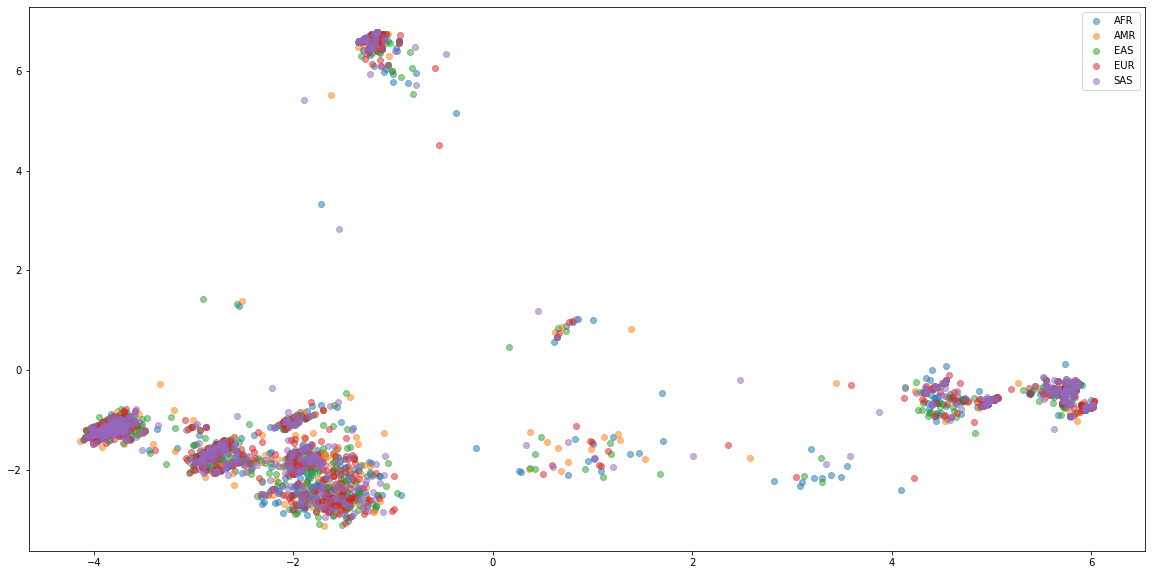

In [12]:
fig, ax = plt.subplots(figsize = (20,10))

for i in range(len(pops)):
    ax.plot(principalComponents[pops == i,0], principalComponents[pops == i,1], "o", alpha=0.5)
ax.legend(populations)

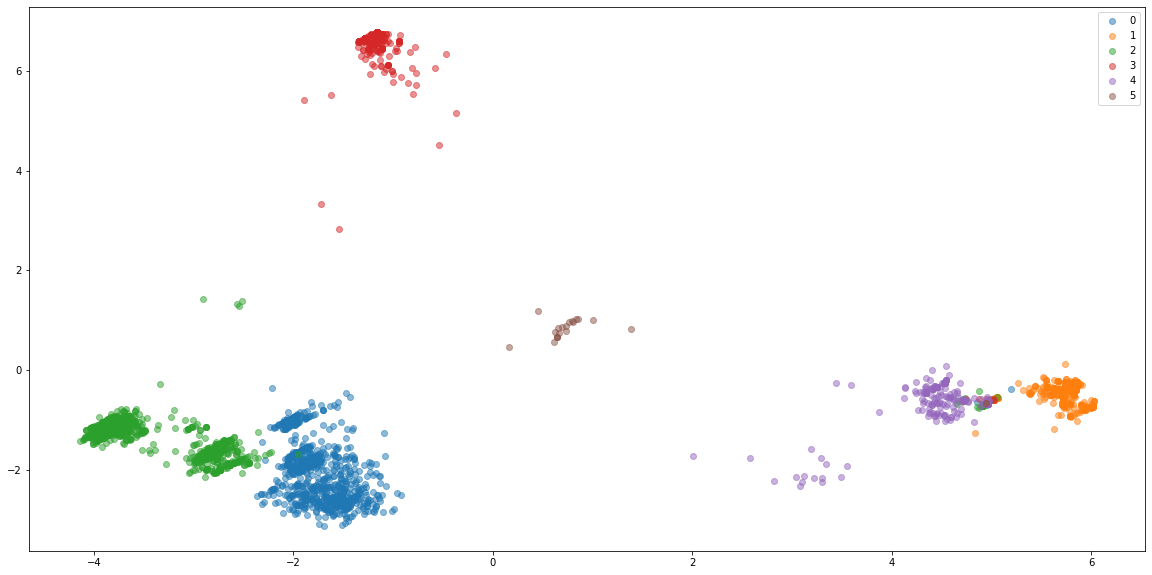

In [13]:
fig, ax = plt.subplots(figsize = (20,10))

for i in range(int(max(models[0].Z))):
    ax.plot(principalComponents[models[0].Z == i,0], principalComponents[models[0].Z == i,1], "o", alpha=0.5)
ax.legend(range(int(max(models[0].Z))))

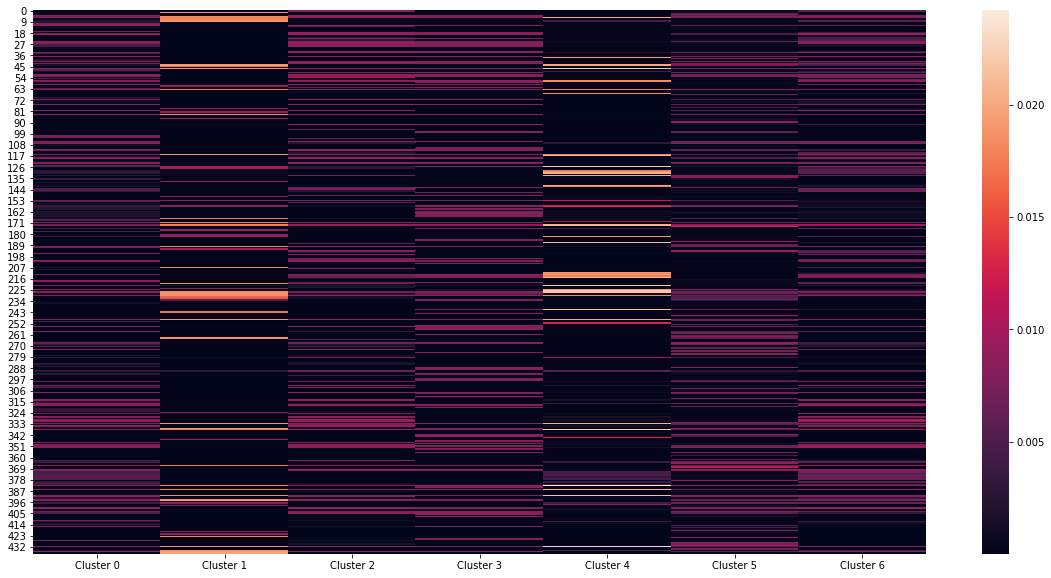

In [14]:
df = pd.DataFrame(dict(zip(["Cluster " + str(i) for i in range(len(models[0].theta))], list(models[0].theta))))
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.heatmap(df)

## Section 5: Sequence Generation

The following builds a sequence generator from the parameters which were determined during model training.

In [15]:
variant_ranges = data_manager.get_variation_range(start = 29941260, end = 29945884, population = "ALL")
mm = AlleleMM(models[0].Z, models[0].theta, inference_matrix, variant_ranges, variation_map)

We can then sample a set of indices which can be mapped to variant ids.

In [40]:
sample = mm.sample_variations()
len(sample)

113

We can compare the samples to the respective cluster. Here the choice of cluster is equally distributed. In the sampling without specified cluster it is determined based on infered paramters, i.e. in reality some clusters might be much more rare than it may seem here.

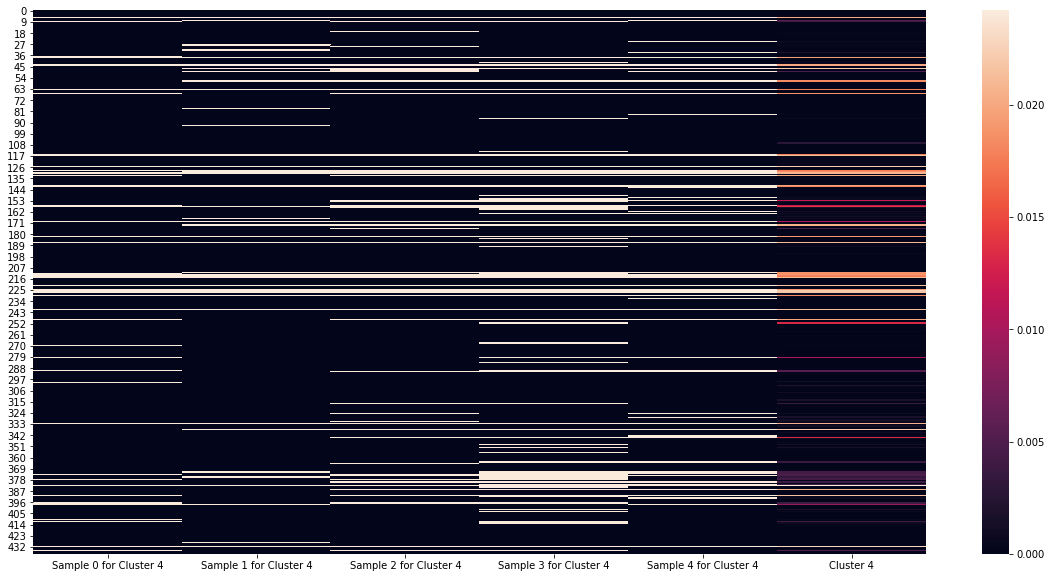

In [59]:
number_of_samples = 5
samples = []
descriptions = []
k = np.random.choice(range(int(max(models[0].Z))))
theta = models[0].theta[k]
indicator_value = theta.max()
for i in range(number_of_samples):
    characteristic_vector = np.zeros(len(theta))
    characteristic_vector[mm.sample_variations(k)] = indicator_value
    samples.append(characteristic_vector)
    descriptions.append("Sample {} for Cluster {}".format(i, k))
samples.append(theta)
descriptions.append("Cluster {}".format(k))
df = pd.DataFrame(dict(zip(descriptions, samples)))
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.heatmap(df)
    